<a href="https://colab.research.google.com/github/Shivdutta/AdvanceCNN/blob/master/Resnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#Reference: https://keras.io/examples/cifar10_resnet/#trains-a-resnet-on-the-cifar10-dataset

In [0]:
from __future__ import print_function
import keras
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model
from keras import optimizers 
import numpy as np
import os
from keras.preprocessing import image
import math
import matplotlib.pyplot as plt

In [0]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

!unzip -q "/content/gdrive/My Drive/CNN_Images/ImagesPred.zip"

Mounted at /content/gdrive/
replace ImagesPred/Images/Test/Dipika/IMG20180110082005.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [0]:
%ls /content/ImagesPred/Images/

Test/  Train/


In [0]:
#Give dataset path
trainpath = "/content/ImagesPred/Images/Train"
testpath = "/content/ImagesPred/Images/Test"

In [0]:
# Training parameters
batch_size = 32  # orig paper trained all networks with batch_size=128
epochs = 200
data_augmentation = True
num_classes = 4

# Subtracting pixel mean improves accuracy
subtract_pixel_mean = True

# Model parameter
# ----------------------------------------------------------------------------
#           |      | 200-epoch | Orig Paper| 200-epoch | Orig Paper| sec/epoch
# Model     |  n   | ResNet v1 | ResNet v1 | ResNet v2 | ResNet v2 | GTX1080Ti
#           |v1(v2)| %Accuracy | %Accuracy | %Accuracy | %Accuracy | v1 (v2)
# ----------------------------------------------------------------------------
# ResNet20  | 3 (2)| 92.16     | 91.25     | -----     | -----     | 35 (---)
# ResNet32  | 5(NA)| 92.46     | 92.49     | NA        | NA        | 50 ( NA)
# ResNet44  | 7(NA)| 92.50     | 92.83     | NA        | NA        | 70 ( NA)
# ResNet56  | 9 (6)| 92.71     | 93.03     | 93.01     | NA        | 90 (100)
# ResNet110 |18(12)| 92.65     | 93.39+-.16| 93.15     | 93.63     | 165(180)
# ResNet164 |27(18)| -----     | 94.07     | -----     | 94.54     | ---(---)
# ResNet1001| (111)| -----     | 92.39     | -----     | 95.08+-.14| ---(---)
# ---------------------------------------------------------------------------


In [0]:
Image_Size =32
  
train_datagen = image.ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)
 
test_datagen = image.ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
        trainpath,
        target_size=(Image_Size, Image_Size),
        batch_size=batch_size,
        class_mode='categorical')
 
validation_generator = test_datagen.flow_from_directory(
        testpath,
        target_size=(Image_Size,Image_Size),
        batch_size=batch_size,
        class_mode='categorical')

Found 32 images belonging to 4 classes.
Found 8 images belonging to 4 classes.


In [0]:
# Model version
# Orig paper: version = 1 (ResNet v1), Improved ResNet: version = 2 (ResNet v2)
version = 1
#depth
n = 1
# Computed depth from supplied model parameter n
if version == 1:
    depth = n * 6 + 2
elif version == 2:
    depth = n * 9 + 2

# Model name, depth and version
model_type = 'ResNet%dv%d' % (depth, version)
model_type

'ResNet8v1'

In [0]:
def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr


In [0]:
def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    """2D Convolution-Batch Normalization-Activation stack builder

    # Arguments
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or
            bn-activation-conv (False)

    # Returns
        x (tensor): tensor as input to the next layer
    """
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x

In [0]:
def resnet_v1(input_shape, depth, num_classes=10):
    """ResNet Version 1 Model builder [a]

    Stacks of 2 x (3 x 3) Conv2D-BN-ReLU
    Last ReLU is after the shortcut connection.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filters is
    doubled. Within each stage, the layers have the same number filters and the
    same number of filters.
    Features maps sizes:
    stage 0: 32x32, 16
    stage 1: 16x16, 32
    stage 2:  8x8,  64
    The Number of parameters is approx the same as Table 6 of [a]:
    ResNet20 0.27M
    ResNet32 0.46M
    ResNet44 0.66M
    ResNet56 0.85M
    ResNet110 1.7M

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 6 != 0:
        raise ValueError('depth should be 6n+2 (eg 20, 32, 44 in [a])')
    # Start model definition.
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)

    inputs = Input(shape=input_shape)
    x = resnet_layer(inputs=inputs)
    # Instantiate the stack of residual units
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:  # first layer but not first stack
                strides = 2  # downsample
            y = resnet_layer(inputs=x,
                             num_filters=num_filters,
                             strides=strides)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters,
                             activation=None)
            if stack > 0 and res_block == 0:  # first layer but not first stack
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])
            x = Activation('relu')(x)
        num_filters *= 2

    # Add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model




In [0]:
def resnet_v2(input_shape, depth, num_classes=10):
    """ResNet Version 2 Model builder [b]

    Stacks of (1 x 1)-(3 x 3)-(1 x 1) BN-ReLU-Conv2D or also known as
    bottleneck layer
    First shortcut connection per layer is 1 x 1 Conv2D.
    Second and onwards shortcut connection is identity.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filter maps is
    doubled. Within each stage, the layers have the same number filters and the
    same filter map sizes.
    Features maps sizes:
    conv1  : 32x32,  16
    stage 0: 32x32,  64
    stage 1: 16x16, 128
    stage 2:  8x8,  256

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 9 != 0:
        raise ValueError('depth should be 9n+2 (eg 56 or 110 in [b])')
    # Start model definition.
    num_filters_in = 16
    num_res_blocks = int((depth - 2) / 9)

    inputs = Input(shape=input_shape)
    # v2 performs Conv2D with BN-ReLU on input before splitting into 2 paths
    x = resnet_layer(inputs=inputs,
                     num_filters=num_filters_in,
                     conv_first=True)

    # Instantiate the stack of residual units
    for stage in range(3):
        for res_block in range(num_res_blocks):
            activation = 'relu'
            batch_normalization = True
            strides = 1
            if stage == 0:
                num_filters_out = num_filters_in * 4
                if res_block == 0:  # first layer and first stage
                    activation = None
                    batch_normalization = False
            else:
                num_filters_out = num_filters_in * 2
                if res_block == 0:  # first layer but not first stage
                    strides = 2    # downsample

            # bottleneck residual unit
            y = resnet_layer(inputs=x,
                             num_filters=num_filters_in,
                             kernel_size=1,
                             strides=strides,
                             activation=activation,
                             batch_normalization=batch_normalization,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_in,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_out,
                             kernel_size=1,
                             conv_first=False)
            if res_block == 0:
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters_out,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])

        num_filters_in = num_filters_out

    # Add classifier on top.
    # v2 has BN-ReLU before Pooling
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [0]:
input_shape = (32,32,3)
input_shape,depth

((32, 32, 3), 8)

In [0]:
if version == 2 :  
    model = resnet_v2(input_shape=input_shape, depth=depth,num_classes=num_classes)
else :
    model = resnet_v1(input_shape=input_shape, depth=depth,num_classes=num_classes)

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=lr_schedule(0)),
              metrics=['accuracy'])
model.summary()
#print(model_type)

Learning rate:  0.001
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 16)   448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 16)   64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 32, 32, 16)   0           batch_normalization_1[0][0]      
______________________________________________________________________

In [0]:
# Prepare model model saving directory.
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'ImagePred_%s_model.{epoch:03d}.h5' % model_type
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

In [0]:
def scheduler(epoch):
  if epoch < 10:
    return 0.001
  else:
    return 0.001 * math.exp(0.1 * (10 - epoch))

# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True,save_weights_only=False, mode='auto',period=1)

lr_scheduler = LearningRateScheduler(scheduler)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

callbacks = [checkpoint,  lr_scheduler]



In [0]:
opt = optimizers.Adam()

model.compile(
    optimizer=opt,
    loss="categorical_crossentropy", 
    metrics=["accuracy"]
)
#model.summary()

In [0]:
histroy= model.fit_generator(
    generator=train_generator,
    steps_per_epoch = len(train_generator),
    validation_data=validation_generator,
    use_multiprocessing=True,
    workers=4, 
    epochs=epochs,
    verbose=1,
    callbacks=callbacks)

Epoch 1/200
Epoch 1/200
1/1 [==============================] - 13s 13s/step - loss: 1.6873 - accuracy: 0.2188 - val_loss: 2.3152 - val_accuracy: 0.2500

Epoch 00001: val_loss improved from inf to 2.31516, saving model to /content/saved_models/ImagePred_ResNet8v1_model.001.h5
Epoch 2/200
1/1 [==============================] - 3s 3s/step - loss: 1.3855 - accuracy: 0.3438 - val_loss: 2.6981 - val_accuracy: 0.2500

Epoch 00002: val_loss did not improve from 2.31516
Epoch 3/200
1/1 [==============================] - 7s 7s/step - loss: 1.1594 - accuracy: 0.6250 - val_loss: 3.3021 - val_accuracy: 0.2500

Epoch 00002: val_loss did not improve from 2.31516

Epoch 00003: val_loss did not improve from 2.31516
Epoch 4/200
1/1 [==============================] - 7s 7s/step - loss: 1.0290 - accuracy: 0.6875 - val_loss: 4.1593 - val_accuracy: 0.2500

Epoch 00004: val_loss did not improve from 2.31516
Epoch 5/200

Epoch 00003: val_loss did not improve from 2.31516
1/1 [==============================] -

In [0]:
Iter_2_200 = keras.models.load_model("/content/saved_models/ImagePred_ResNet8v1_model.200.h5")

In [0]:
import numpy as np
from keras.preprocessing import image

#test_image = image.load_img('/content/ImagesPred/Images/Test/Dipika/IMG20180110082005.jpg', target_size = (Image_Size, Image_Size))
#test_image = image.load_img('/content/ImagesPred/Images/Test/Shiv/IMG20200102162934.jpg', target_size = (Image_Size, Image_Size))
#test_image = image.load_img('/content/ImagesPred/Images/Test/Siddhant/IMG20191015153026.jpg', target_size = (Image_Size, Image_Size))
test_image = image.load_img('/content/ImagesPred/Images/Test/Turtle/IMG20200418194924_01.jpg', target_size = (Image_Size, Image_Size))

test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
train_generator.class_indices
result = Iter_2_200.predict(test_image)
train_generator.class_indices
train_generator.class_indices,result[0][0],result[0][1],result[0][2],result[0][3]

({'Dipika': 0, 'Shiv': 1, 'Siddhant': 2, 'Turtle': 3}, 0.0, 1.0, 0.0, 0.0)

In [0]:
if result[0][0] == 1:
    prediction = 'Dipika'
    print(prediction)
elif result[0][1] == 1:
    prediction = 'Shiv'
    print(prediction)
elif result[0][2] == 1:
    prediction = 'Siddhant'
    print(prediction)
elif result[0][3] == 1:
    prediction = 'Turtle'
    print(prediction)
else:
    prediction = 'Not able to predict'
    print(prediction)

Shiv


In [0]:
histroy_Iter2= Iter_2_200.fit_generator(
    generator=train_generator,
    steps_per_epoch = len(train_generator),
    validation_data=validation_generator,
    use_multiprocessing=True,
    workers=4, 
    epochs=epochs,
    verbose=1,
    callbacks=callbacks)

Epoch 1/200
1/1 [==============================] - 10s 10s/step - loss: 0.3474 - accuracy: 0.9688 - val_loss: 0.9676 - val_accuracy: 0.6250

Epoch 00001: val_loss improved from inf to 0.96760, saving model to /content/saved_models/ImagePred_ResNet8v1_model.001.h5
Epoch 2/200
1/1 [==============================] - 4s 4s/step - loss: 0.3193 - accuracy: 1.0000 - val_loss: 1.0270 - val_accuracy: 0.6250

Epoch 00002: val_loss did not improve from 0.96760
Epoch 3/200
1/1 [==============================] - 7s 7s/step - loss: 0.3243 - accuracy: 0.9375 - val_loss: 1.0265 - val_accuracy: 0.6250

Epoch 00003: val_loss did not improve from 0.96760
Epoch 4/200
1/1 [==============================] - 7s 7s/step - loss: 0.3049 - accuracy: 0.9688 - val_loss: 0.9677 - val_accuracy: 0.6250

Epoch 00004: val_loss did not improve from 0.96760
Epoch 5/200
1/1 [==============================] - 7s 7s/step - loss: 0.2608 - accuracy: 0.9688 - val_loss: 0.9112 - val_accuracy: 0.6250

Epoch 00005: val_loss impro

In [0]:
#Below result is run of 50 epoch
results = Iter_2_200.evaluate_generator(train_generator, verbose=1)
dict(zip(Iter_2_200.metrics_names, results))

1/1 [==============================] - 5s 5s/step


{'accuracy': 1.0, 'loss': 0.14033430814743042}

In [0]:
#Below result is run of 50 epoch
results = Iter_2_200.evaluate_generator(validation_generator, verbose=1)
dict(zip(Iter_2_200.metrics_names, results))

1/1 [==============================] - 2s 2s/step


{'accuracy': 0.625, 'loss': 1.1726881265640259}

Text(0.5, 1.0, 'Loss vs Epochs')

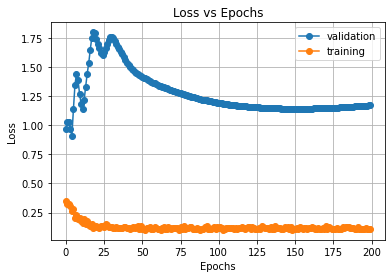

In [0]:
plt.plot(histroy_Iter2.epoch,histroy_Iter2.history['val_loss'],'-o',label='validation')
plt.plot(histroy_Iter2.epoch,histroy_Iter2.history['loss'],'-o',label='training')

plt.grid(True)
plt.legend(loc=0)

plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.title('Loss vs Epochs')

Text(0.5, 1.0, 'Learning Rate vs Epochs')

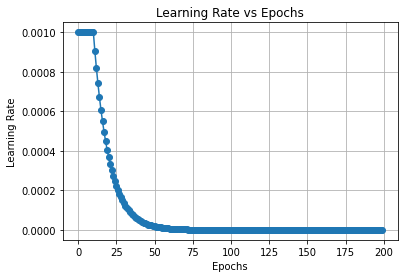

In [0]:
plt.plot(histroy_Iter2.epoch, histroy_Iter2.history['lr'],'-o')

plt.grid(True)
plt.xlabel('Epochs')
plt.ylabel('Learning Rate')
plt.title('Learning Rate vs Epochs')

Text(0.5, 1.0, 'Accuracy vs Epochs')

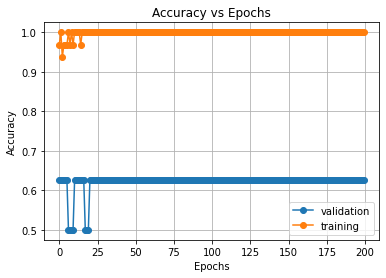

In [0]:

plt.plot(histroy_Iter2.epoch,histroy_Iter2.history['val_accuracy'], '-o', label='validation')
plt.plot(histroy_Iter2.epoch,histroy_Iter2.history['accuracy'], '-o', label='training')

plt.grid(True)
plt.legend(loc=0)

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epochs')